<a href="https://colab.research.google.com/github/manukala6/processing/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [0]:
import os
import ee
import sys
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

**Authenticate and Initialize**

In [0]:
ee.Initialize()

**Collect Imagery from Assets**

In [0]:
# links to earth engine image assets
naiman_image_links = [
  'users/manukala6/naimanResiduals/naimanResiduals1985',
  'users/manukala6/naimanResiduals/naimanResiduals1986',
  'users/manukala6/naimanResiduals/naimanResiduals1987',
  'users/manukala6/naimanResiduals/naimanResiduals1988',
  'users/manukala6/naimanResiduals/naimanResiduals1989',
  'users/manukala6/naimanResiduals/naimanResiduals1991',
  'users/manukala6/naimanResiduals/naimanResiduals1992',
  'users/manukala6/naimanResiduals/naimanResiduals1993',
  'users/manukala6/naimanResiduals/naimanResiduals1994',
  'users/manukala6/naimanResiduals/naimanResiduals1995',
  'users/manukala6/naimanResiduals/naimanResiduals1996',
  'users/manukala6/naimanResiduals/naimanResiduals1997',
  'users/manukala6/naimanResiduals/naimanResiduals1998',
  'users/manukala6/naimanResiduals/naimanResiduals1999',
  'users/manukala6/naimanResiduals/naimanResiduals2000',
  'users/manukala6/naimanResiduals/naimanResiduals2001',
  'users/manukala6/naimanResiduals/naimanResiduals2002',
  'users/manukala6/naimanResiduals/naimanResiduals2003',
  'users/manukala6/naimanResiduals/naimanResiduals2004',
  'users/manukala6/naimanResiduals/naimanResiduals2005']

# earth engine geometry of study area
study_area = ee.Geometry.Polygon(
        [[[120.81731549446476, 43.28530172879357],
              [120.81731549446476, 43.10960397992836],
              [121.08510724251164, 43.10960397992836],
              [121.08510724251164, 43.28530172879357]]])

In [0]:
naiman_images = []
for image_link in naiman_image_links:
  naiman_images.append(ee.Image(image_link))

**Convert EarthEngine ImageCollection to numpy array of shape** `(num_years, num_bands, num_rows, num_cols)`

In [0]:
# function to convert an EarthEngine Image to numpy array
def convert_ee2arr (ee_image):
  # get the lat lon and add the ndvi
  latlon = ee.Image.pixelLonLat().addBands(ee_image)
  # apply reducer to list
  latlon = latlon.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=study_area,
    maxPixels=1e8,
    scale=30);
  # get data into three different arrays
  ndvi = np.array((ee.Array(latlon.get('ndviCalendar')).getInfo()))
  prec = np.array((ee.Array(latlon.get('precipitation')).getInfo()))
  lats = np.array((ee.Array(latlon.get('latitude')).getInfo()))
  lons = np.array((ee.Array(latlon.get('longitude')).getInfo()))
  # get the unique coordinates
  uniqueLats = np.unique(lats)
  uniqueLons = np.unique(lons)
  # get number of columns and rows from coordinates
  ncols = len(uniqueLons)   
  nrows = len(uniqueLats)
  # determine pixelsizes
  ys = uniqueLats[1] - uniqueLats[0]
  xs = uniqueLons[1] - uniqueLons[0]
  # create an array with dimensions of image
  ndvi_arr = np.zeros([nrows, ncols], np.float32) #-9999
  prec_arr = np.zeros([nrows, ncols], np.float32) #-9999
  # fill the array with values
  counter = 0
  for y in range(0, ndvi_arr.shape[0], 1):
      for x in range(0, ndvi_arr.shape[1], 1):
          if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
              counter += 1
              ndvi_arr[len(uniqueLats)-1-y, x] = ndvi[counter] # start from lower left corner
              prec_arr[len(uniqueLats)-1-y, x] = prec[counter] # start from lower left corner
  # stack ndvi and precipitation
  return np.stack((ndvi_arr, prec_arr))

In [101]:
# do the thing
nyears = 2
naiman_arr_images = []
for i in tqdm(range(nyears), ncols=100):
  naiman_arr_images.append(convert_ee2arr(naiman_images[i]))






  0%|                                                                         | 0/2 [00:00<?, ?it/s]




 50%|████████████████████████████████▌                                | 1/2 [00:18<00:18, 18.46s/it]




100%|█████████████████████████████████████████████████████████████████| 2/2 [00:34<00:00, 17.76s/it]






In [0]:
# stack into one array of shape len(naiman_images)
naiman_arr = np.asarray(naiman_arr_images)

In [103]:
# check the shape
print('number of years: ', naiman_arr.shape[0])
print('number of bands: ', naiman_arr.shape[1])
print('number of cols:  ', naiman_arr.shape[2])
print('number of rows:  ', naiman_arr.shape[3])

number of years:  2
number of bands:  2
number of cols:   652
number of rows:   993


**Image Verification**

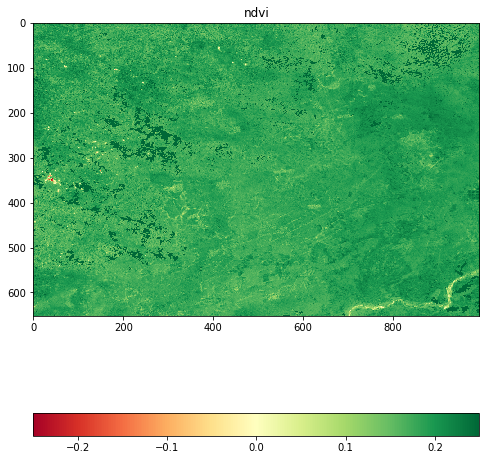

In [104]:
# select year 4 (1989), band 0 (ndvi)
test_img = naiman_arr[1, 0]

# plot image
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(test_img, cmap=plt.get_cmap('RdYlGn'))
imgplot.set_clim(-0.25, 0.25)
ax.set_title('ndvi')
plt.colorbar(orientation='horizontal')

**Regression**

In [105]:
# obtain ndvi and prec bands from each array image
ndvi = naiman_arr[:,0]
prec = naiman_arr[:,1]
nrows = ndvi.shape[1]
ncols = ndvi.shape[2]
# verify shape
ndvi.shape, prec.shape

((2, 652, 993), (2, 652, 993))

In [106]:
# append slope an intercept per pixel into array
slopes = np.array([])
intercepts = np.array([])
for row in tqdm(range(nrows), ncols=100):
  for col in range(ncols):
    x = prec[:,row,col].reshape((-1,1))
    y = ndvi[:,row,col]
    model = LinearRegression().fit(x, y)
    slopes = np.append(slopes, model.coef_[0])
    intercepts = np.append(intercepts, model.intercept_)






  0%|                                                                       | 0/652 [00:00<?, ?it/s]




  0%|                                                               | 1/652 [00:00<04:28,  2.42it/s]




  0%|▏                                                              | 2/652 [00:00<04:20,  2.49it/s]




  0%|▎                                                              | 3/652 [00:01<04:19,  2.50it/s]




  1%|▍                                                              | 4/652 [00:01<04:15,  2.53it/s]




  1%|▍                                                              | 5/652 [00:01<04:12,  2.56it/s]




  1%|▌                                                              | 6/652 [00:02<04:13,  2.54it/s]




  1%|▋                                                              | 7/652 [00:02<04:12,  2.56it/s]




  1%|▊                                                              | 8/652 [00:03<04:12,  2.55it/s]




  1%|▊                                            

In [0]:
# reshape
slopes = slopes.reshape(nrows, ncols)
intercepts = intercepts.reshape(nrows, ncols)

In [0]:
# compute residuals
residual_list = []
for year in range(nyears):
  this_prec = prec[year]
  this_ndvi = ndvi[year]
  pred_ndvi = np.multiply(slopes, this_prec)
  pred_ndvi = np.add(pred_ndvi, intercepts)
  residual = np.subtract(pred_ndvi, this_ndvi) * -1
  residual_list.append(residual)
residuals = np.asarray(residual_list)

In [109]:
residuals.shape

(2, 652, 993)

**Verify**

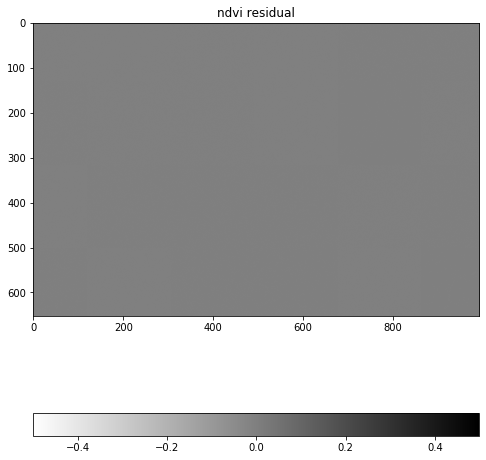

In [115]:
# select year
residual = residuals[1]

# plot residual
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1, 1, 1)
resplot = plt.imshow(residual, cmap=plt.get_cmap('binary'))
resplot.set_clim(-0.5, 0.5)
ax.set_title('ndvi residual')
plt.colorbar(orientation='horizontal')

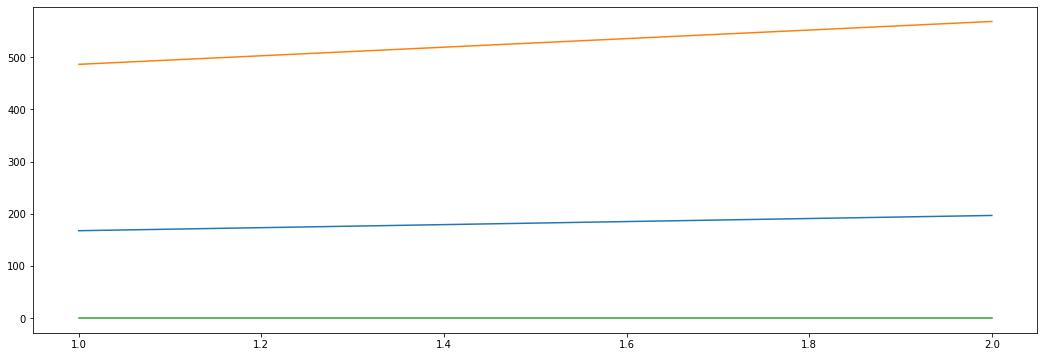

In [116]:
# plot trends for a specific point
row = 128
col = 458

years_list = [year + 1 for year in range(nyears)]
years = np.asarray(years_list)
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(years, ndvi[:,row,col]*1000)
ax.plot(years, prec[:,row,col])
ax.plot(years, residuals[:,row,col]*1000)

**Save as GeoTIFF**

In [0]:
dst = rio.open(
    'x.tif',
    'w',
    driver='GTiff',
    dtype=slopes.dtype,
    width=slopes.shape[1],
    height=slopes.shape[0],
    count=1,
    crs='EPSG:4326',
    transform=(1.0, 0.0, 457163.0, 0.0, -1.0, 4426952.0)
)
dst.write(slopes,1)
dst.close()

In [0]:
with rio.open('x.tif') as src:
  naiman_raster = src.read()

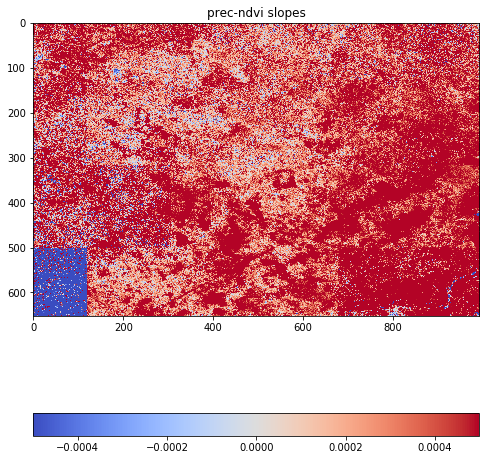

In [114]:
# plot slopes
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1, 1, 1)
resplot = plt.imshow(naiman_raster[0,:,:], cmap=plt.get_cmap('coolwarm'))
resplot.set_clim(-0.0005, 0.0005)
ax.set_title('prec-ndvi slopes')
plt.colorbar(orientation='horizontal')